# Train a PdM Agent using Behavior Cloning

- 25-Jul-2024: V.1.0 - Re-create
- 28-Jul-2024: V.1.1 - Add logging
- 28-Jul-2024: V.2.0 - Add other algos to compare with BC
  1. SQIL is straightforward and similar to BC implementation 
  2. Adversarial IRL and GAIL - appear to require Discriminator and therefore a "Reward Net" - more complex so do next

In [1]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

# Custom libraries
from milling_tool_env import MillingTool

In [2]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")

PATH = 'D:/ResearchLab/IRL/BC_for_PdM_July_2024/'
LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'
writer = SummaryWriter(LOG_PATH)
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/BC_for_PdM_July_2024//tensorboard/30-Jul-2024_21_02/


In [3]:
SAMPLE_DEMONSTRATIONS = 10
EPISODES = 200 # Train the Expert for N episodes
BATCH_SIZE = 16 
LEARNING_RATE = int(1e-3)
EVALUATION_ROUNDS = 10

# Milling tool env.
DATA_FILE = 'PHM_C01.csv'
R1, R2, R3 = 2.0, -1.0, -20.0
WEAR_THRESHOLD = 0.12 # mm
THRESHOLD_FACTOR = 1.0
ADD_NOISE = 0 # 0=No noise, Low=1e3, High=1e2 
BREAKDOWN_CHANCE = 0 # Recommended: 0.05 = 5%
MILLING_OPERATIONS_MAX = 300

## 1. Creating the PdM Milling tool environment

In [4]:
## Read tool-wear data
df = pd.read_csv(DATA_FILE)
WEAR_MIN = df['tool_wear'].min() 
WEAR_MAX = df['tool_wear'].max()
WEAR_THRESHOLD_NORMALIZED = THRESHOLD_FACTOR*(WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = np.where(df_normalized['tool_wear'] < WEAR_THRESHOLD_NORMALIZED, 0.0, 1.0)
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')
df_train = df_normalized

gym.register(
    id = 'custom/MillingTool-v0',
    entry_point = MillingTool,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

Tool wear data imported (1000 records). WEAR_THRESHOLD_NORMALIZED: 0.574


### Create the Milling environent 
- Default method of creating is `env_mt = gym.make('custom/MillingTool-v0')`
- This does **not** work with `imitation` IRL
- Must create a vectorized env. using `make_vec_env` utility

In [5]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'df':df_train, 'wear_threshold':WEAR_THRESHOLD_NORMALIZED, 'max_operations':MILLING_OPERATIONS_MAX,
               'add_noise':ADD_NOISE, 'breakdown_chance':BREAKDOWN_CHANCE, 'R1':R1, 'R2':R2, 'R3':R3}

mt_venv = make_vec_env(
    'custom/MillingTool-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)

# Load the wear data dataframe
# mt_venv.load_df(df=df_train)

** -- Milling Tool Wear Single-variate env. Wear_threshold: 1.0000 R1: 1.0, R2: -1.0, R3: -100.0. Noise: 0.0. Break-down chance: 0.0 -- **
** -- Envoronment closed. Data-frame memory *NOT* released. Garbage collector invoked successfully -- **
** -- Milling Tool Wear Single-variate env. Wear_threshold: 0.5744 R1: 2.0, R2: -1.0, R3: -20.0. Noise: 0. Break-down chance: 0 -- **


## 2. The "Human" Expert (here we create one)

In [6]:
# expert_a2c = A2C('MlpPolicy', env_mt)
# expert_a2c.learn(total_timesteps=EPISODES)

In [7]:
expert_ppo = PPO(
    policy = MlpPolicy,
    env = mt_venv,
    # seed = 0,
    batch_size = 64,
    ent_coef = 0.0,
    learning_rate = LEARNING_RATE,
    n_epochs = 10,
    n_steps = 64,
    tensorboard_log=LOG_PATH,
)

expert_ppo.learn(EPISODES) 

Check PPO Expert reward

In [8]:
reward, _ = evaluate_policy(expert_ppo, mt_venv, EVALUATION_ROUNDS)
print(f'PPO Expert reward: {reward}')

# reward, _ = evaluate_policy(expert_a2c, env_mt, 10)
# print(reward)

PPO Expert reward: 8999.899999999998


## 3. Demonstrations from the the Expert

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [9]:
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

transitions = rollout.flatten_trajectories(rollouts)

Let's have a quick look at what we just generated using those library functions:

```print(f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
""")```

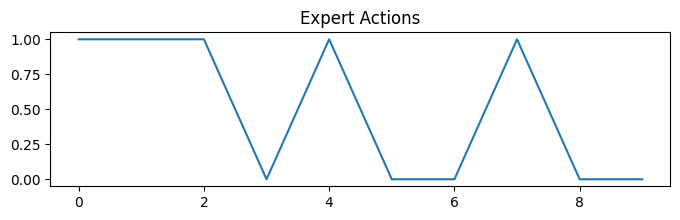

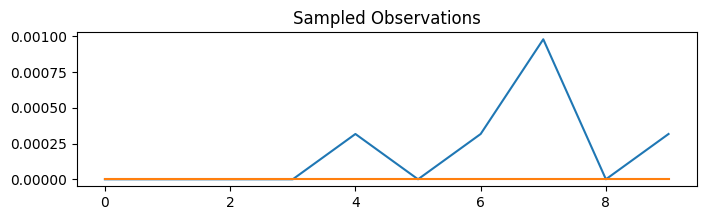

In [10]:
import matplotlib.pyplot as plt
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(transitions.acts[n])
    obsvs.append(transitions.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

After we collected our transitions, it's time to set up our behavior cloning algorithm.

In [11]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

bc_trainer = bc.BC(
    observation_space=mt_venv.observation_space,
    action_space=mt_venv.action_space,
    demonstrations=transitions,
    batch_size=BATCH_SIZE,
    rng=rng,
    device='cpu',
    custom_logger = new_logger_irl
)

As you can see the untrained policy only gets poor rewards:

In [12]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

Reward before training: -405.000


## 4. Behavioural Cloning (BC) based learning from expert demonstrations

In [13]:
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 68.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 16        |
---------------------------------


178batch [00:00, 323.05batch/s]
187batch [00:00, 294.29batch/s]


In [14]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

------------------------------------------------------------------------------------------------------------------------
 **** IRL with Imitation Libraries and Milling environment ****
------------------------------------------------------------------------------------------------------------------------
30-Jul-2024  21:02:51
Episodes: 200
Rewards Before: -405.000 | After: -903.000


In [15]:
from imitation.algorithms import sqil
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

sqil_trainer = sqil.SQIL(   
    venv = mt_venv,
    demonstrations = transitions,
    policy='MlpPolicy',
    # device='cpu',
    custom_logger = new_logger_irl
)

In [16]:
from stable_baselines3.common.evaluation import evaluate_policy

reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
print(f"Reward before training: {reward_before_training:5.3f}")

Reward before training: 8999.899999999998


In [18]:
sqil_trainer.train(
    total_timesteps = 10_000, # Note: set to 1_000_000 to obtain good results
)  
reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
print(f"Reward after training: {reward_after_training:5.3f}")

Reward after training: 8999.900


In [ ]:
# sqil_trainer.train(
#     total_timesteps=1_000_000, # Note: set to 1_000_000 to obtain good results
# )  
# reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
# print(f"Reward after training: {reward_after_training}")